# CSCI-UA 0473 - Introduction to Machine Learning
## Homework 4

The task for this homework is again that of handwritten digit recognition on the MNIST dataset. From the huge corpus of 70k images, I have sampled 3k images uniformly i.e. there are 300 images in each class.

I have split the 3k samples into training set (2500 points) and test set (500 points) randomly. This experimental dataset is the same for all and I have provided the pickle files with the corresponding data.

In this homework, you will be experimenting with different distance functions and number of bases used for the RBF Network. No complicated (or simple, for some) coding involved. Only play with the distance function and the number of bases.

Conduct your experiments in a principled way to decide the best distance function according to you and the optimal value of number of bases for the best distance function. Use the accuracy score as the evaluation metric.

Explain your approach clearly in the write-up.

Report your experiment results using plots (preferably) or tables with the accuracies in the write-up.

(EXTRA CREDITS) Come up with your own distance function, explain it clearly and provide the results from your distance function.

In [1]:
import autograd.numpy as np
from autograd import grad
import scipy.optimize
import scipy.spatial.distance
import pickle

import matplotlib.pyplot as plot
%matplotlib inline

## 1. Data

In [2]:
training_data = pickle.load(open('training_data_hw4.p', 'rb'))
training_labels = pickle.load(open('training_labels_hw4.p', 'rb'))

test_data = pickle.load(open('test_data_hw4.p', 'rb'))
test_labels = pickle.load(open('test_labels_hw4.p', 'rb'))


print ('Training Data: ', training_data.shape)
print ('Test Data: ', test_data.shape)

print ('Training Label Distribution: ', np.bincount(training_labels))
print ('Test Label Distribution: ', np.bincount(test_labels))

('Training Data: ', (2500, 784))
('Test Data: ', (500, 784))
('Training Label Distribution: ', array([249, 253, 253, 246, 249, 248, 245, 244, 261, 252]))
('Test Label Distribution: ', array([51, 47, 47, 54, 51, 52, 55, 56, 39, 48]))


## 2. RBF - Experiment Here

In [3]:
def rbf(x, bases, width=1., metric="euclidean"):
#     return np.exp(-(((x[:,None,:] - bases[None,:,:]) ** 2).sum(-1) / width))
    return np.exp(-scipy.spatial.distance.cdist(x, bases, metric))

In [69]:
# Keep track of this variable for your computations. It's a global variable and it's value 
# will be reflected in many functions.

n_bases = 1800

## 3. Model Definition

In [5]:
'''
Definition of the multinomial logistic regression model.

INPUT: Feature vector (x) and weight matrix (w)
OUTPUT: The probability of each data point belonging to each class. If you have 'm' data points and 'k' classes, this 
        function should return a matrix of dimension (m X k) with values in each row summing to 1, as per definition.
'''

def multinomial_logreg(x, w):  
     
    y = np.dot(x, w.reshape(n_bases, 10))
    
    y_ = np.exp(y)
    
    return y_ / y_.sum(axis=1, keepdims=True)

In [6]:
'''
Distance function of the multinomial logistic regression model (popularly called cross-entropy loss). 

INPUT: True labels (y), feature vector (x) and weight vector (w)
OUTPUT: Log of the likelihood for the given 'w'
'''

def multinomial_lr_distance(y, x, w):
    y_pred = multinomial_logreg(x, w)
    
    distance = -(np.mean([y_pred[i, y[i]] for i in range(x.shape[0])]))
    
    return distance

In [7]:
def cost(w, x, y):
    return multinomial_lr_distance(y, x, w)

# Computing the gradient
multinomial_lr_rule = grad(cost)

In [8]:
def _multinomial_lr_dist(w, x, y):
    return multinomial_lr_distance(y, x, w), multinomial_lr_rule(w, x, y)

## 4. Training 

In [71]:
# Select random centroids
cids = np.random.permutation(len(training_data))[:n_bases]
all_centroids = training_data[cids]

x_tra_ = rbf(training_data, all_centroids, 1.) 

In [10]:
x_tra_.shape

(2500, 1800)

In [11]:
w0 = 0.01 * np.random.randn(n_bases, 10); w0[:, -1] = 0.
print w0.shape
w = np.copy(w0)

trained_model = scipy.optimize.minimize(_multinomial_lr_dist, w0, (x_tra_, training_labels), method='L-BFGS-B', jac=True)

(1800, 10)


In [12]:
w_learned = trained_model.x.reshape((n_bases, 10))

In [13]:
w_learned.shape

(1800, 10)

## 5. Play Area - Different Distance Functions and Number of Bases

In [14]:
y_train_pred = multinomial_logreg(x_tra_, w_learned)

In [15]:
print 'Train Accuracy (Euclidean): ', np.sum(training_labels == np.argmax(y_train_pred, axis = 1)) * 1. / training_data.shape[0]

Train Accuracy (Euclidean):  0.7536


## 6. Testing

In [72]:
# WRITE CODE TO FIND THE TEST ACCURACY USING YOUR EXPERIMENTAL SETUP
functions = ["braycurtis", "canberra", "chebyshev", "cityblock", "correlation", "cosine", "dice", "euclidean", "hamming", "jaccard", "kulsinski", "matching", "minkowski", "rogerstanimoto", "russellrao", "seuclidean", "sokalmichener", "sokalsneath", "sqeuclidean", "yule"]

max_val = 0
max_fun = ""
k = 1

for func in functions:
    x_tra_ = rbf(training_data, all_centroids, 1., func) 
    trained_model = scipy.optimize.minimize(_multinomial_lr_dist, w0, (x_tra_, training_labels), method='L-BFGS-B', jac=True)
    w_learned = trained_model.x.reshape((n_bases, 10))
    y_train_pred = multinomial_logreg(x_tra_, w_learned)
    
    tes_acc = np.sum(training_labels == np.argmax(y_train_pred, axis = 1)) * 1. / training_data.shape[0]
    if(tes_acc > max_val):
        max_val = tes_acc
        max_fun = func
print(max_fun)

/Users/rossfreeman/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide


cosine


In [76]:
max_val = 0
max_k = 0
acc = dict()

for k in xrange(1900, 1950, 10):
    n_bases = k
    
    cids = np.random.permutation(len(training_data))[:n_bases]
    all_centroids = training_data[cids]
    
    w0 = 0.01 * np.random.randn(n_bases, 10); w0[:, -1] = 0.
    w = np.copy(w0)
    
    x_tra_ = rbf(training_data, all_centroids, 1., max_fun) 
    trained_model = scipy.optimize.minimize(_multinomial_lr_dist, w0, (x_tra_, training_labels), method='L-BFGS-B', jac=True)
    w_learned = trained_model.x.reshape((n_bases, 10))
    x_test = rbf(test_data, all_centroids, 1., max_fun)
    y_test_pred = multinomial_logreg(x_test, w_learned)
    
    tes_acc = np.sum(test_labels == np.argmax(y_test_pred, axis = 1)) * 1. / test_data.shape[0]
    acc[k] = tes_acc
    if(tes_acc > max_val):
        max_val = tes_acc
        max_k = k

/Users/rossfreeman/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide


{1920: 0.078, 1940: 0.38600000000000001, 1930: 0.19600000000000001, 1900: 0.38, 1910: 0.19400000000000001}


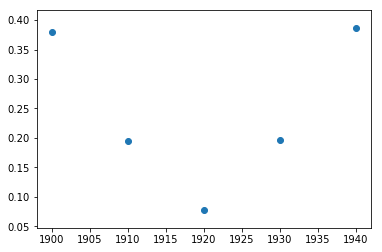

In [77]:
print(acc)
plot.scatter(acc.keys(), acc.values())
plot.show()

In [73]:
print(max_val)

0.266
